# New York Taxi Fare Prediction Using `Pytorch`

## Reference
- [Dataset Link](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction)

## Outline
- Prepare Notebook
- Load Dataset
- Explore and Preprocess Dataset
- Config GPU
- Linear Model
    - Model Defining
    - Model Training
    - Evaluation
- Testing and Submission
- Hypothesis Testing ( Optional )

Hi 👋, This Notebook I used to practice some `Deep Learning` concepts. I will explain the code one by one. Feel free to use this notebook for yourselves.

*Upvote if you ❤*

## Logs
#### 05-01-2023 Started this notebook and working

### Prepare Notebook

First things First, We have to import some important packages and setup our notebook

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={"figure.figsize":(10, 8)})

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

### Load Dataset

Next thing we will load our files into pandas first and next we can convert it into `tensors`. First let's check our parent directory and next files by files

In [2]:
PARENT_DIR = '/kaggle/input/new-york-city-taxi-fare-prediction/'

os.listdir(PARENT_DIR)

['sample_submission.csv',
 'GCP-Coupons-Instructions.rtf',
 'train.csv',
 'test.csv']

There are four files in which we only three. `sample_submission.csv`, `train.csv`, `test.csv`. We can use only these files for our notebook. Let's load them into our pandas

In [3]:
# df = pd.read_csv(PARENT_DIR + 'train.csv')

"""
Loading full file will take more ram, because train.csv has 55 Million rows. So we set limit in the rows while loading
"""

df = pd.read_csv(PARENT_DIR + 'train.csv', nrows = 1_000_00)

test_df = pd.read_csv(PARENT_DIR + 'test.csv')

submission_df = pd.read_csv(PARENT_DIR + 'sample_submission.csv')

### Explore and Preprocess Dataset

We finish loading all three files. Let's explore and preprocess these files.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


In [5]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


**Key Insights**
- Maximum `passenger_count` in a taxi 2, But there are maximum count upto 6. Taxi can't ride with six passengers unless it's a bus.
- New york's Coordinates range should above 40 ( Latitude ) and below -73 ( Longitude ) for Pickup and Dropoff. [Refer Here](https://www.latlong.net/place/new-york-city-ny-usa-1848.html_).
- The Minimum `fare_amount` is negative

In [6]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
pd.DataFrame(df['pickup_datetime'].describe())

,pickup_datetime
count,100000
unique,98245
top,2011-10-11 18:30:00+00:00
freq,3
first,2009-01-01 00:41:00+00:00
last,2015-06-30 22:54:07+00:00


Dataframe contains only values ranging from year `2009` to `2015`. This means, we have only takes values from these because we limit the rows while loading into pandas

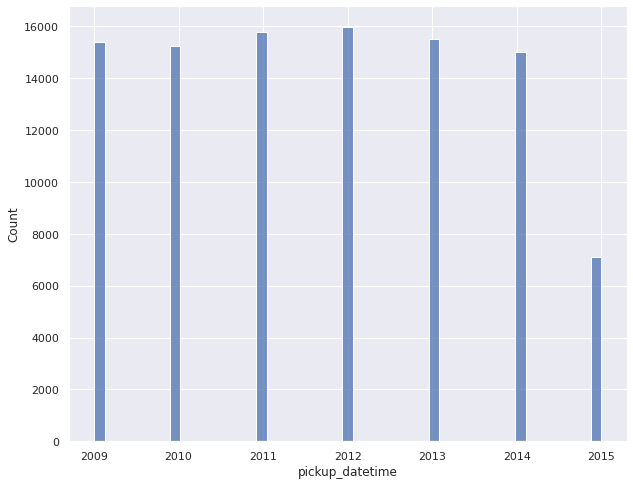

In [7]:
# Question - 1 Which year from 2009 to 2015 has highest taxi rides

sns.histplot(df['pickup_datetime'].dt.year)
plt.show()

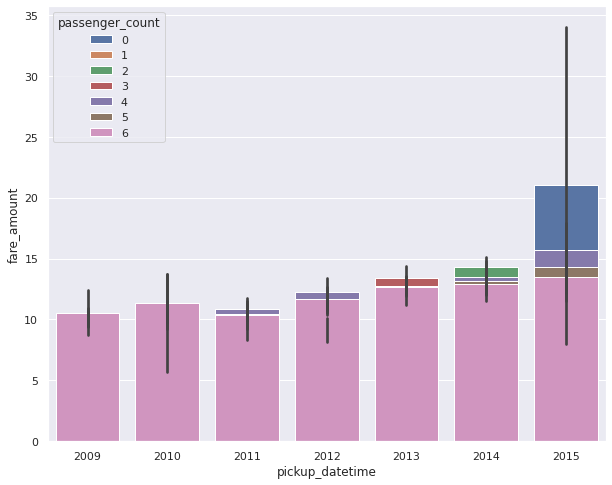

In [10]:
# Question 2 - Which year has more taxi fares ?

sns.barplot(x = df['pickup_datetime'].dt.year, y = df['fare_amount'], hue = df['passenger_count'], dodge = False)
plt.show()

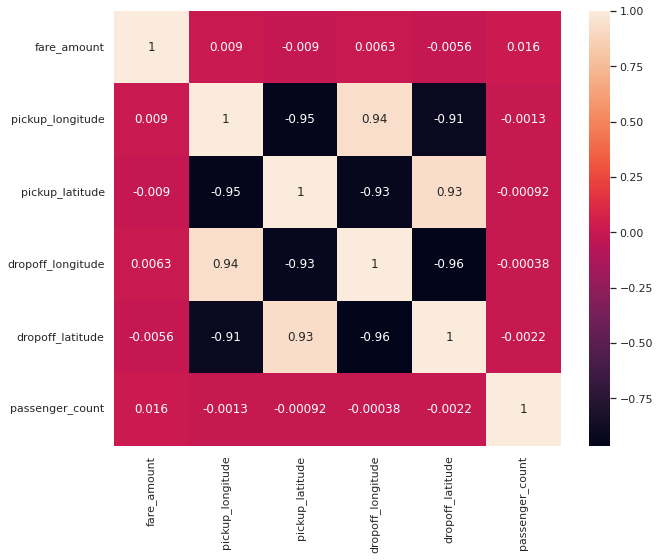

In [22]:
# Question - 3 How did Features correlate with eachother ?

sns.heatmap(df.corr(), annot = True)
plt.show()

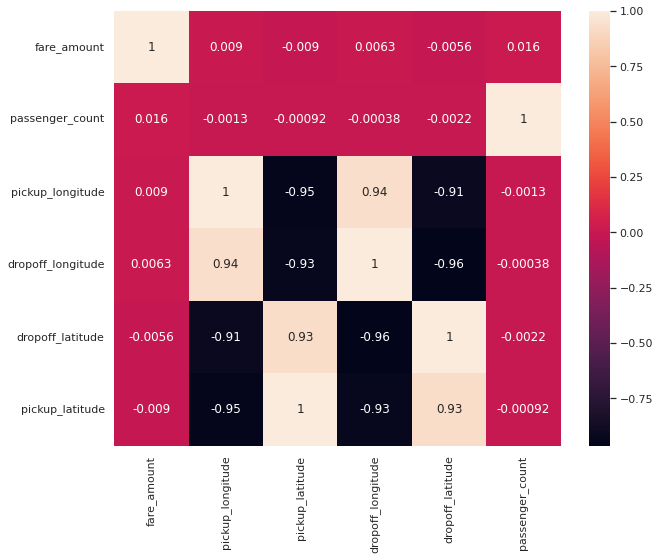

In [26]:
# Question - 4 How did feature correlate with target value ?

sns.heatmap(df.corr().sort_values(by = 'fare_amount', ascending = False), annot = True)
plt.show()